In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import tqdm

In [3]:
batch_size = 16
nc = 3
ndf = 4
lr = 0.0005

In [4]:
dataset_train = dset.ImageFolder(root='/content/drive/MyDrive/facades_train/',
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_test = dset.ImageFolder(root='/content/drive/MyDrive/facades_test/',
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

In [6]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


class ResNetUNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.base_model = torchvision.models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, nc, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.photo = nn.Sequential(
            nn.Conv2d(nc, ndf, 6, 2, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, bias=False),
            Flatten(),
            nn.Linear(576, 64)
        )
        
        self.segment = nn.Sequential(
            nn.Conv2d(nc, ndf, 6, 2, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, bias=False),
            Flatten(),
            nn.Linear(576, 64)
        )
        self.linear1 = nn.Linear(128, 32)
        self.linear2 = nn.Linear(32, 1)

    def forward(self, input_photo, input_segment):
        photo = self.photo(input_photo)
        segment = self.segment(input_segment)
        result = F.relu(torch.cat([photo, segment], dim=1))
        result = F.relu(self.linear1(result))
        result = torch.sigmoid(self.linear2(result))
        return result

In [8]:
def plot_losses(d_losses, g_losses):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)

    n_epochs = len(d_losses) - 1
    x_train = np.linspace(0, n_epochs, len(d_losses))
    x_test = np.arange(n_epochs + 1)

    ax.plot(x_train, d_losses, label='Ошибка дискриминатора')
    ax.plot(x_test, g_losses, label='Ошибка генератора')
    ax.legend()
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Ошибка')
    plt.show()

In [9]:
netG = ResNetUNet().to(device)
netD = Discriminator().to(device)

criterionMSE = torch.nn.MSELoss()
criterionL1 = torch.nn.L1Loss()

optimizerD = optim.Adam(netD.parameters(), lr=lr)
optimizerG = optim.Adam(netG.parameters(), lr=lr)

In [11]:
G_losses = []
D_losses = []

for epoch in tqdm.tqdm(range(40)):
    G_losses_epoch = []
    D_losses_epoch = []
    for i, data in enumerate(dataloader_train):

        netD.zero_grad()
        real_photo = data[0][:,:,:,:256].to(device)
        real_segment = data[0][:,:,:,256:].to(device)
        b_size = real_photo.size(0)
        label = torch.full((b_size,), 1., dtype=torch.float, device=device)
        output = netD(real_photo, real_segment).view(-1)
        errD_real = criterionMSE(output, label)
        errD_real.backward()

        fake = netG(real_segment)
        real_segment = data[0][:,:,:,256:].to(device)
        label.fill_(0.)
        output = netD(fake.detach(), real_segment).view(-1)
        errD_fake = criterionMSE(output, label)
        errD_fake.backward()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        real_segment = data[0][:,:,:,256:].to(device)
        real_photo = data[0][:,:,:,:256].to(device)
        fake = netG(real_segment)
        label = torch.full((b_size,), 1., dtype=torch.float, device=device)
        output = netD(fake, real_segment).view(-1)
        errG1 = criterionMSE(output, label)
        errG2 = criterionL1(fake, real_photo) * 10
        errG = errG1 + errG2
        errG.backward()
        optimizerG.step()

        G_losses_epoch.append(errG.item())
        D_losses_epoch.append(errD.item())

    G_losses.append(sum(G_losses_epoch) / len(G_losses_epoch))
    D_losses.append(sum(D_losses_epoch) / len(D_losses_epoch))

100%|██████████| 40/40 [32:40<00:00, 49.02s/it]


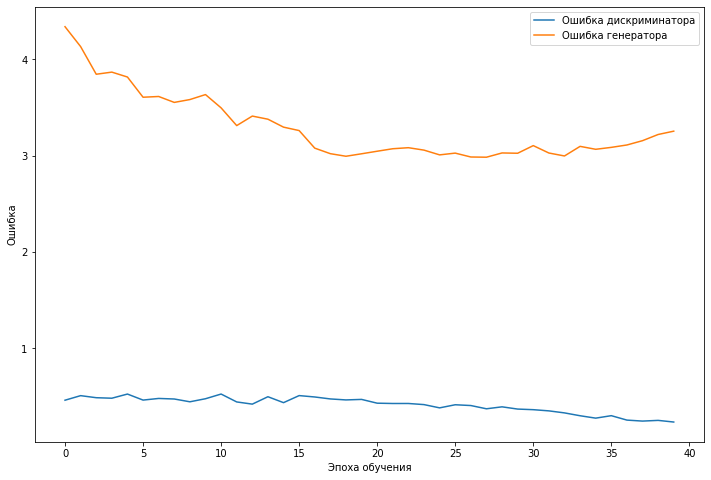

In [13]:
plot_losses(D_losses, G_losses)

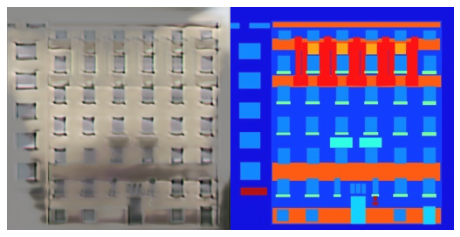

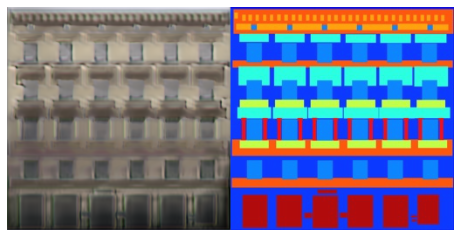

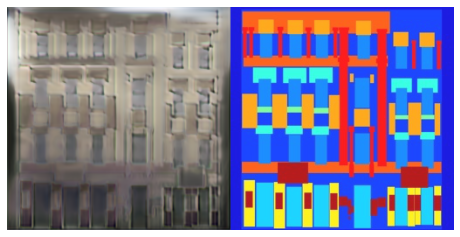

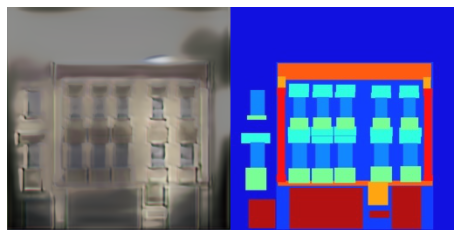

In [14]:
test_batch = next(iter(dataloader_test))
test_imgs = test_batch[:4]
segment = test_batch[0][:4,:,:,256:]
with torch.no_grad():
    fake = netG(segment.to(device)).detach().cpu()
result = torch.cat([fake, segment], dim=-1)
for i in range(4):
    img = result[i].reshape(1,3,256,512)

    plt.figure(figsize=(8,16))
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(img.to(device), padding=2, normalize=True).cpu(),(1,2,0)))
    plt.show()